In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff, MapDataset, MapDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker, MapDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, Map, WcsGeom
from gammapy.modeling.models import (
    TemplateSpatialModel, PowerLawNormSpectralModel, SkyModel, FoVBackgroundModel, Models, 
    PowerLawSpectralModel, GaussianSpatialModel
)

In [2]:
from gammapy.utils.check import check_tutorials_setup

# check_tutorials_setup()

In [3]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)



livetime = 50.0 * u.hr

source_coord = SkyCoord.from_name("Geminga")

geom = RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 1)", axes=[energy_axis])
# geom = RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 100)", axes=[energy_axis], binsz_wcs=0.02 * u.deg)

pointing = source_coord


# geom = WcsGeom.create(
#     skydir=pointing,
#     width=(2, 2),
#     binsz=0.02,
#     frame="icrs",
#     axes=[energy_axis],
# )

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [4]:
geom

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 20)
	ndim       : 3
	frame      : icrs
	center     : 98.4 deg, 17.8 deg

In [5]:
irfs = load_cta_irfs(
    # "$GAMMAPY_DATA/1.0/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits",
    "./Prod5-South-20deg-SouthAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
    # "$GAMMAPY_DATA/1.0/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)
location = observatory_locations["cta_south"]
pointing = SkyCoord.from_name("Geminga")


In [6]:
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime=livetime, location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
spectrum_dataset = spectrum_maker.run(empty_dataset, obs)

containment = 0.68

# correct exposure
spectrum_dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
spectrum_dataset.background *= factor.value.reshape((-1, 1, 1))


In [7]:
print(spectrum_dataset)

SpectrumDataset
---------------

  Name                            : n7O-dp2S 

  Total counts                    : 0 
  Total background counts         : 78116.96
  Total excess counts             : -78116.96

  Predicted counts                : 78116.96
  Predicted background counts     : 78116.96
  Predicted excess counts         : nan

  Exposure min                    : 1.97e+06 m2 s
  Exposure max                    : 4.08e+11 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [8]:
filename = "allenergies_TeV.fits"
m = Map.read(filename)

m = m.copy(unit="1 / (cm2 TeV s sr)")

# spatial_model = TemplateSpatialModel(m, filename=filename, normalize=False)
spatial_model = GaussianSpatialModel(lon_0=source_coord.ra, lat_0=source_coord.dec, sigma="3 deg", frame="icrs")
# Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(), spatial_model=spatial_model, name="Geminga-template-model")
Geminga_model = SkyModel(spectral_model=PowerLawSpectralModel(), spatial_model=spatial_model, name="Geminga-template-model")

# m.plot_grid()

# bkg_spectral_model = PowerLawSpectralModel(
#     index=2.7, amplitude="1e6 cm-2 s-1 TeV-1", reference="1 TeV")

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model = FoVBackgroundModel(spectral_model=bkg_spectral_model, dataset_name="dataset-simu")

#models = Models([bkg_model])
models = Models([Geminga_model,bkg_model])
print(models)

print(models.to_yaml())

Models

Component 0: SkyModel

  Name                      : Geminga-template-model
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     98.476   +/-    0.00 deg         
    lat_0                         :     17.770   +/-    0.00 deg         
    sigma                         :      3.000   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : Powe

In [9]:
empty = MapDataset.create(geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="dataset-simu")

obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

# maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=5.0 * u.deg)

print("making dataset")
dataset = maker.run(empty, obs)
# dataset = maker_safe_mask.run(dataset, obs)
print("dataset made!")

dataset.models = models

print(dataset)


Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 98.5 deg, 17.8 deg

	deadtime fraction : 0.0%

making dataset
dataset made!
MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 1976581.53
  Total excess counts             : -1976581.53

  Predicted counts                : 1977104.39
  Predicted background counts     : 1976581.53
  Predicted excess counts         : 522.87

  Exposure min                    : 2.90e+06 m2 s
  Exposure max                    : 6.00e+11 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3954208.79

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name  

In [10]:
dataset_on_off = MapDatasetOnOff.from_map_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

dataset_spectrum_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=spectrum_dataset, acceptance=1, acceptance_off=5
)

In [11]:
dataset_on_off.npred_signal().data.shape

(20, 1, 1)

In [12]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

/home/savchenk/miniconda-recent/envs/gammapy-1.0.1/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:349: RuntimeWarning: Tolerance of -6.469217623816803e-07 reached.
  warnings.warn(msg, RuntimeWarning)


In [13]:

spectrum_sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10, 
    # spectrum= PowerLawSpectralModel(index=2.7, amplitude="1 cm-2 s-1 TeV-1")
    # spectrum=Geminga_model.spectral_model
)
spectrum_sensitivity_table= spectrum_sensitivity_estimator.run(dataset_spectrum_on_off)

In [14]:
emin_cta, flux_cta = np.loadtxt('CTA_point_source_left.txt',unpack=True) # E[TeV], E^2 * Flux Sensitivity [erg cm^2/s]
emax_cta, flux_cta = np.loadtxt('CTA_point_source_right.txt',unpack=True)
emean_cta, flux_cta = np.loadtxt('CTA_point_source_mean.txt',unpack=True)

In [15]:
# check this out, data for 
# https://zenodo.org/record/5499840#.YUya5WYzbUI
# https://docs.gammapy.org/1.0.1/tutorials/analysis-1d/cta_sensitivity.html?highlight=sensitivity

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,1.17575e-09,9904.51,99045.1,bkg
0.0503641,2.85182e-10,37351.3,373513,bkg
0.0711412,9.18974e-11,54979.5,549795,bkg
0.10049,5.57002e-11,43348.5,433485,bkg
0.141945,3.9218e-11,23442.1,234421,bkg
0.200503,2.33961e-11,11647.2,116472,bkg
0.283218,1.44538e-11,6462.78,64627.8,bkg
0.400056,9.72323e-12,3809.91,38099.1,bkg


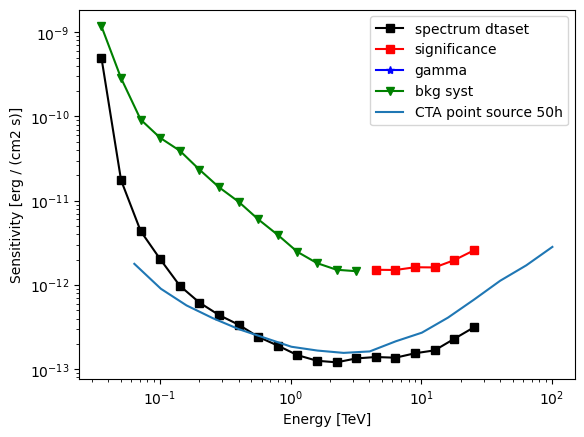

In [16]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    spectrum_sensitivity_table["energy"],    
    spectrum_sensitivity_table["e2dnde"],
    "s-",
    color="black",
    label="spectrum dtaset",
)

ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

plt.errorbar(emean_cta[2:-1],flux_cta[2:-1],label='CTA point source 50h')


ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()

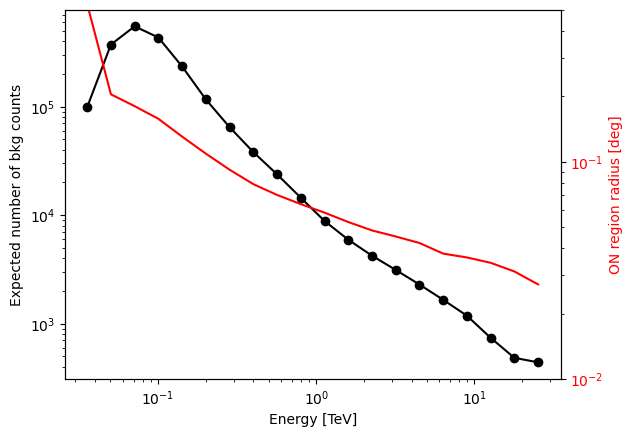

In [17]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(t["energy"], t["background"], "o-", color="black", label="blackground")

ax1.loglog()
ax1.set_xlabel(f"Energy [{t['energy'].unit}]")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius [{on_radii.unit}]", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)
plt.show()